# Исследование трендов

# Алгоритм

- Выгрузить данные патентов, статей, запросов, инвестиций.
- Обработать выгруженные данные - привести к одному виду, соединить.
- Нормализовать ключевые слова.
- По ключевым словам кластеризовать уже обработанные данные.
- Интерпретировать кластеры, задать им название тренда.
- Разложить каждый тренд на временной ряд.
- Каждая единица временного ряда должна содержать данные о количестве патентов, статей, запросов, стартапов и инвестициях в долларах.
- Нормализовать данные к диапазону [0,1] или стандартизировать.
- С помощью 5 нормализованных переменных (патенты, статьи, запросы, стартапы, инвестиции) получить целевую переменную.
- Для получения целевой переменной будет использоваться следующая формула: y = (П + С + З + СТ + ИН / СТ) / П

## Устанавливаем необходимые библиотеки

In [0]:
!pip install pandas
!pip install pymorphy2
!pip install xlrd
!pip install openpyxl
!pip install seaborn
!pip install sklearn

     |████████████████████████████████| 9.7 MB 20.4 MB/s 
     |████████████████████████████████| 510 kB 45.5 MB/s 
     |████████████████████████████████| 96 kB 6.4 MB/s 
     |████████████████████████████████| 243 kB 17.1 MB/s 
     |████████████████████████████████| 285 kB 14.6 MB/s 
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1316 sha256=862fe97227ce2fd2eaba515e97892730cdb3efb940215caf014ee2e710f3118d
  Stored in directory: /home/datalore/.cache/pip/wheels/22/0b/40/fd3f795caaa1fb4c6cb738bc1f56100be1e57da95849bfc897
Successfully built sklearn


## Импортируем необходимые библиотеки

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## Выгружаем данные. На примере Scopus, GooglePatents, Arxiv.

### Выгрузка данных из Scopus

Данные извлекаются при помощи [API Scopus](https://elsevierscience.ru/files/ScopusAPI_QRG_Rus.pdf). Можно парсить самостоятельно ([пример](https://stackoverflow.com/questions/30513808/scopus-keywords-and-citations-crawling) как это делать).

Есть библиотека **[pybliometrics](https://pybliometrics.readthedocs.io/en/stable/examples/ScopusSearch.html)**-это простая в использовании библиотека Python для извлечения, кэширования данных из Scopus. Установка командой ```!pip install pybliometrics``` или ```!pip install git+https://github.com/pybliometrics-dev/pybliometrics```

Также для использования pybliometrics я получила у Scopus institutional token для расширенного доступа к БД. Это инфо добавляется вручную в файл config.ini следующим образом:\
[Authentication]\
APIKey = \*\*\*\*\
InstToken = ***

Можно указать несколько ключей доступа через запятую. Тогда при превышении лимитов pybliometrics будет использовать другой ключ.

**Подробнее про лимиты**

Данная информация получена из [**переписки с разработчиками pybliometrics**](https://github.com/pybliometrics-dev/pybliometrics/issues/192)

ScopusApi прредоставляет слудующие [лимиты](https://www.elsevier.com/de-de/events/scopus-community-anwendertreffen?a=917179) на запросы:
![](scopus_limits.png)

Институциональный токен фактически дает права подписчика. В зависимости от того, какое представление использовать при запросе (COMPLETE ИЛИ STANDART) рассчитывается итоговое количество страниц результатов:

Те если запрос возвращает 30 822, то для представления COMPLETE - это будет 30,822/25 ~1233 страниц результатов. Для представления STANDART 30 822/200 ~ 155 страниц результатов. Однако представление STANDART дает меньше полей. Всего подписчику в течении недели доступно 20000 страниц. Результаты запросов при параметре download=True, сохраняются в кэш.

**Пример запроса к Scopus для сферы HR**
___________________________

- Отрасль знаний Бизнес, менеджмент и бухгалтерское дело (BUSI) тк именно эта область по описанию содержит искомые данные
- Наличие в названии, кратком описании (abstract) и ключах следующих слов и словосочетаний:\
collective, personnel,staff, human resource, human resource management,  employee, organizational, resource management, personnel,  department,  workforce, manpower 
- Год публикации PUBYEAR  >  2009 

In [0]:
# Выгрузка данных из SCOPUS для сферы HR
def pybliometrics_extract_save_csv(query,file_name,view_type='COMPLETE'):
    
    """ Выгрузка данных из Scopus и их сохранение в csv
        
        Parameters
        ----------
        query     : str, запрос к scopus
        
        file_name : str, имя csv файла
            
        view_type : str,доступны 2 значения парамтра: STANDARD(200 batches) и COMPLETE(25 batches), 
                    но в COMPLETE больше атрибутов, рекомендуется к использованию, установлен по 
                    умолчанию
                    
        Returns
        -------
        Сохраняет csv файл с названием file_name"""
    
    
    import pandas as pd
    from pybliometrics.scopus import ScopusSearch
    
    query_result = ScopusSearch(query,subscriber=True,view=view_type)
    print(query_result.get_key_reset_time()) # время обновления
    print(query_result.get_key_remaining_quota()) # остаток от лимита
    print(query_result.get_results_size()) #кол-во строк, не страниц в результате запроса
    df = pd.DataFrame(pd.DataFrame(query_result.results))
    df.to_csv(file_name)

    #Уберем часть слов и журналов из запроса
query = """
        TITLE-ABS-KEY (collective OR personnel  OR  "staff"  OR  
                       (human AND resources) OR (human AND resource) OR
                       (human AND resource AND management) OR employee OR
                       organizational OR (resource AND management) OR  
                       (personnel AND department) OR workforce OR manpower) AND  
         SUBJAREA (busi) AND  
         PUBYEAR > 2009
         """

pybliometrics_extract_save_csv(query,'hr_2010.csv',view_type='COMPLETE')

К сожалению запрос выполнятеся долго, чтобы его запускать заново, поэтому скрин результатов выполнения запроса.
![](scopus_ex_1.png)

Описание полей данных Scopus в итоговом наборе(описание всех получаемых данных доступно в документации [API Scopus](https://dev.elsevier.com/sc_search_views.html)):

`subtypeDescription - Описание типа документа (Document Type description)`\
`creator - First Author`\
`author_count - Количество авторов`\
`author_names - Имя автора`\
`author_ids- ID авторов (Author ID)`\
`coverDate - Дата публикации (Publication Date(YYYY-MM-DD))`\
`publicationName - Источник (Source Title)`\
`aggregationType - Тип источника (Source Type)`\
`description - Аннотация (Abstract)`\
`authkeywords - Ключевые слова автора (Author Keywords)`\
`citedby_count - Цитирования (Cited-by Count)`\
`openaccess - Статус принадлежности к журналу открытого доступа (Open Access status)`\

In [0]:
import pandas as pd
import datetime as dt

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


data = pd.read_csv('hr_2010_journ_keyword_change2.csv')
#Отбор столбцов
data = data[['doi', 'title',  'subtypeDescription', 'creator', 'author_count', 'author_names', 'author_ids', 'coverDate', 'publicationName', 'aggregationType', 'description', 'authkeywords', 'citedby_count', 'openaccess']]
#Преобразование типа даты в данных 
data['coverDate'] = pd.to_datetime(data['coverDate'])
print('\033[1mРазмер набора данных:\033[0m',data.shape)
print('\033[1mСтолбцы\033[0m',list(data.columns))
print('\033[1mПропущено значений в authkeywords:\033[0m{}%'.format(round(data['authkeywords'].isnull().sum()/data.shape[0]*100,2)))
print('\033[1mТипы данных\033[0m',data.dtypes)
print('\033[1mКоличество источников публикации\033[0m',len(set(data['publicationName'])))

#Обработка значений ключевых фраз
data['authkeywords'] = data['authkeywords'].str.lower()
data['authkeywords'] = data['authkeywords'].str.replace('\"','')
data['authkeywords'] = data['authkeywords'].str.replace('#','')
data['authkeywords'] = data['authkeywords'].str.replace('-','')
data['authkeywords'] = data['authkeywords'].str.replace('&amp;','')
data['authkeywords'] = data['authkeywords'].str.replace('\'','')
data['authkeywords'] = data['authkeywords'].str.replace('(','',regex=False)
data['authkeywords'] = data['authkeywords'].str.replace(')','',regex=False)
data['authkeywords'] = data['authkeywords'].str.replace('&ltp, f&gt','')
data['authkeywords'] = data['authkeywords'].str.replace('&ltp','')
data['authkeywords'] = data['authkeywords'].str.replace('f&gt','')
data['authkeywords'] = data['authkeywords'].str.replace(';','')
data['authkeywords'] = data['authkeywords'].str.replace('�','')
data['authkeywords'] = data['authkeywords'].str.replace('\ue4f8degree','degree')
data['authkeywords'] = data['authkeywords'].str.replace('a i  ','')
data['authkeywords'] = data['authkeywords'].str.replace('360°','360')
data['authkeywords'] = data['authkeywords'].str.replace('360degree','360 degree')
data['authkeywords'] = data['authkeywords'].str.replace('360 feedback','360 degree feedback')




# data['authkeywords'] = data['authkeywords'].str.replace('employee development|','employee development',regex=False)
data.loc[43718,'authkeywords'] = data.loc[43718,'authkeywords'].replace('employee development|','employee development')

spec_chars = ["!",'"',"#","%","&","'","(",")",
              "*","+",",","-",".","/",":",";","<",
              "=",">","?","@","[","]","^","_",
              "`","{","}","~","–",'°','ue4f8']
for char in spec_chars:
    data['authkeywords'] = data['authkeywords'].str.replace(char, ' ')
data.head()

Размер набора данных: (160032, 14)
Столбцы ['doi', 'title', 'subtypeDescription', 'creator', 'author_count', 'author_names', 'author_ids', 'coverDate', 'publicationName', 'aggregationType', 'description', 'authkeywords', 'citedby_count', 'openaccess']
Пропущено значений в authkeywords:18.01%
Типы данных doi                           object
title                         object
subtypeDescription            object
creator                       object
author_count                 float64
author_names                  object
author_ids                    object
coverDate             datetime64[ns]
publicationName               object
aggregationType               object
description                   object
authkeywords                  object
citedby_count                  int64
openaccess                     int64
dtype: object
Количество источников публикации 7955


/opt/anaconda3/envs/minimal/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (26) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-4-cea43ca37f40-v2qMDT73qMFXHtzW92LiCQ>:50: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  data['authkeywords'] = data['authkeywords'].str.replace(char, ' ')


,doi,title,subtypeDescription,creator,author_count,author_names,author_ids,coverDate,publicationName,aggregationType,description,authkeywords,citedby_count,openaccess
0,10.11118/EJOBSAT.V5I2.175,Smart information system capabilities of digit...,Article,Nürk J.,1.0,"Nürk, Jochen",57221686182,2021-12-23,European Journal of Business Science and Techn...,Journal,This study explores how supply chain managemen...,alignment | artefacts | capabilities | industr...,0,1
1,10.1057/s41599-021-00753-6,On the evolution of social ties as an instrume...,Article,Liu C.W.J.,3.0,"Liu, Chester Wai Jen;Shen, Sheng Feng;Liu, Wei...",56098786700;35093166300;36077509200,2021-12-01,Humanities and Social Sciences Communications,Journal,Human is a highly cultural species with divers...,NaN,0,1
2,10.1186/s11782-021-00100-1,Role of authentic leadership and personal mast...,Article,Fateh A.,3.0,"Fateh, Adnan;Mustamil, Norizah;Shahzad, Fakhar",57218128967;56481552800;56954784500,2021-12-01,Frontiers of Business Research in China,Journal,Personality dispositions and their role in ind...,authentic leadership | autonomous motivation |...,0,1
3,10.1057/s41599-021-00742-9,Predicting organizational performance from mot...,Article,Jobira A.F.,2.0,"Jobira, Askalech Feyisa;Mohammed, Abdulnasir A...",57222376578;57222376607,2021-12-01,Humanities and Social Sciences Communications,Journal,Motivation is one of the most researched yet c...,NaN,0,1
4,10.1186/s13731-020-00143-3,Enhancing innovation speed through trust: a ca...,Article,Mitcheltree C.M.,1.0,"Mitcheltree, Christina Marie",57215046455,2021-12-01,Journal of Innovation and Entrepreneurship,Journal,Trust in organizations plays an essential role...,case study | defensive routines | health care ...,0,1


Далее в целях дополнительной фильтрации первичных ключевых фраз сделаем отбор по журналам на основе:

1. [ТОП 40](https://www.scimagojr.com/journalrank.php?category=1407) журналов scimagojr 2020 в области знаний(subject areas) Organizational Behavior and Human Resource Management.\
Исследовательская группа [SCImago](https://www.scimagojr.com) (Университет Гранады, Испания) занимается аналитикой научно-технической информации, используя информацию из международного индекса цитирования Scopus. Группой был разработан SCImago Journal Rank (SJR) - индикатор влияния научных журналов, который рассчитывается на основе числа цитирований статей данного журнала, а также значимости журналов цитирующих публикаций. Индикатор SJR является бесплатной альтернативой широко известному импакт-фактору и использует аналогичную формулу расчёта.

2. Обогащение списка журналов журналами в уже выгруженном из scopus наборе данных, которые содержат в названии Human Resource.

Из списка на основе 2х источников журналов в финале отберем журналы с количеством публикаций >100.

In [0]:
#Данные scimagojr 2020 
#Источник: https://www.scimagojr.com/journalrank.php?category=1407
scimagojr_2020 = pd.read_excel('scimagojr_2020.xls')
scimagojr_2020_top40 = scimagojr_2020[scimagojr_2020['Rank']<=40]
scimagojr_2020_title = list(scimagojr_2020_top40['Title'])
scimagojr_2020_title[:5]

['Academy of Management Annals',
 'Annual Review of Organizational Psychology and Organizational Behavior',
 'Organization Science',
 'Personnel Psychology',
 'Journal of Human Resources']

In [0]:
#Формирование списка журналов, которые содержат в названии Human Resource или human resource
searchfor = ['Human Resource','human resource']
human_resource_journal_list = list(set(data.loc[data['publicationName'].str.contains('|'.join(searchfor)),'publicationName']))
print('Количество журналов с Human Resource и human resource в названии human_resource_journal_list',len(human_resource_journal_list))
#Объединение списков журналов и удаление дубликатов
final_hr_list = human_resource_journal_list+scimagojr_2020_title
final_hr_list = list(set(final_hr_list))
print('Итоговое количество журналов для отбора final_hr_list',len(final_hr_list))

Количество журналов с Human Resource и human resource в названии human_resource_journal_list 146
Итоговое количество журналов для отбора final_hr_list 181


In [0]:
#Отберем данные по сформированному списку изданий
frame_select_hr_list = data.loc[(data['publicationName'].isin(final_hr_list))&(data['authkeywords'].isnull()==False)]
#Посчитаем количество статей у издания
hr_lis_pub_count = frame_select_hr_list['publicationName'].value_counts()
#Журналы с количеством статей больше 100
series_select_hr_ov40 = hr_lis_pub_count[hr_lis_pub_count>=100]

hr_list_ov40 = list(series_select_hr_ov40.index)
print('Итого изданий',len(hr_list_ov40))
series_select_hr_ov40[:5]

Итого изданий 31


International Journal of Human Resource Management    1588
Human Resource Management International Digest         949
Organization Science                                   558
Organization Studies                                   532
Human Resource Management                              499
Name: publicationName, dtype: int64

In [0]:
# Отбор данных по супер-списку журналов
data_select_hr_journal = data.loc[data['publicationName'].isin(hr_list_ov40)]
#Уберу строки с пустыми ключевыми фразами
data_select_hr_journal = data_select_hr_journal.loc[data_select_hr_journal['authkeywords'].isnull()==False]
print('Размер набора данных для исследования',data_select_hr_journal.shape)
data_select_hr_journal.isnull().sum()

Размер набора данных для исследования (10378, 14)


doi                     0
title                   0
subtypeDescription      8
creator               504
author_count          504
author_names          504
author_ids            504
coverDate               0
publicationName         0
aggregationType         0
description           227
authkeywords            0
citedby_count           0
openaccess              0
dtype: int64

### Выгрузка данных из GooglePatents

In [0]:
!pip install GooglePatents # Библиотека написана специально для решения поставленой задачи. (Документация к библиотеке пока отсутствует)

     |████████████████████████████████| 115 kB 29.5 MB/s 
     |████████████████████████████████| 6.8 MB 46.1 MB/s 


In [0]:
from GooglePatents.API import GooglePatents

In [0]:
googlePatents = GooglePatents()

In [0]:
googlePatents.setQuery('personnel OR staff OR HR OR (human AND resources) OR employee OR organizational OR performance OR HR OR HRM OR (resource AND management) OR (collective AND staff) OR (personnel AND department) OR hrm OR hr OR workforce OR manpower')

In [0]:
patents = googlePatents.getAllPagePatents() # Данный метод по умолчанию создает файл patents.json

In [0]:
# Это скорее метаданные о всех полученных патентах
patents

In [0]:
pd.read_json('patents.json')

,title,snippet,priority_date,filing_date,grant_date,publication_date,inventor,assignee,publication_number,language,thumbnail,pdf,figures,family_metadata
0,Biosensor <b>performance</b> indicator for in...,Methods and apparatuses for monitoring either...,2017-06-26,2018-06-26,2020-05-05,2020-05-05,Yaser Shanjani,"Align Technology, Inc.",US10639134B2,en,e2/21/0c/7a1b93d2e4306b/US10639134-20200505-D0...,8c/03/7a/d74f35b21145f1/US10639134.pdf,[{'thumbnail': '2b/40/e4/79e20bac8df094/US1063...,{'aggregated': {'country_status': [{'country_c...
1,Coatings for enhancement of properties and <b...,A method of improving <b>performance</b> of a...,2015-02-13,2018-09-06,NaN,2019-04-04,Bryan C. Hendrix,"Entegris, Inc.",US20190100842A1,en,e5/1d/f1/4cacdbf30bba1b/US20190100842A1-201904...,81/23/ce/51468374f278b4/US20190100842A1.pdf,[{'thumbnail': '09/f4/e2/32176efc1aa050/US2019...,{'aggregated': {'country_status': [{'country_c...
2,High <b>performance</b> battery anodes with p...,Self-Healing Polymer for Lithium Metal Anodes...,2015-08-31,2016-08-30,2020-03-24,2020-03-24,Zhenan Bao,The Board Of Trustees Of The Leland Stanford J...,US10601049B2,en,01/96/2e/c1809fbba05349/US10601049-20200324-D0...,f1/59/fb/485b47d01d2852/US10601049.pdf,[{'thumbnail': '58/8a/44/1743e2dcda5c4b/US1060...,{'aggregated': {'country_status': [{'country_c...
3,Light-emitting devices and displays with impr...,Light-emitting devices and displays with impr...,2006-06-02,2019-05-17,2020-09-08,2020-09-08,Seth Coe-Sullivan,"Samsung Electronics Co., Ltd.",US10770619B2,en,6c/60/9b/21d6cc75af7ed3/US10770619-20200908-D0...,ac/d4/fe/a92adbd4530191/US10770619.pdf,[{'thumbnail': '21/22/ee/5f4e3b3f044a22/US1077...,{'aggregated': {'country_status': [{'country_c...
4,High-<b>performance</b> rechargeable batterie...,A high-<b>performance</b> rechargeable batter...,2009-09-25,2016-11-22,2017-06-27,2017-06-27,Joseph C. Farmer,"Lawrence Livermore National Security, Llc",US9692078B2,en,09/91/1f/9052fa67d9bf1e/US09692078-20170627-D0...,c7/3c/4e/94354895cd93e5/US9692078.pdf,[{'thumbnail': 'd9/e9/cd/2b4dabd328a9be/US0969...,{'aggregated': {'country_status': [{'country_c...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,"Node device, repeater and methods for use the...","claim 1 , further comprising: a controller co...",2015-07-23,2020-01-10,2020-10-20,2020-10-20,Paul Shala Henry,"At&T Intellectual Property I, L.P.",US10812191B2,en,e6/49/24/8bca3f9c4c4e69/US10812191-20201020-D0...,2f/1e/49/76f5bfac72132b/US10812191.pdf,[{'thumbnail': '4e/fa/df/64596b387b50d6/US1081...,{'aggregated': {'country_status': [{'country_c...
996,Dispositif de vaporisation <b>personnel</b>,Dispositif de vaporisation <b>personnel</b> (...,2015-12-18,2016-12-15,2021-02-03,2021-02-03,Aled JAMES,JT International S.A.,EP3386323B1,fr,14/bd/06/02edb6b987442f/imgf0001.png,52/a2/f1/78a4fdd345a096/EP3386323B1.pdf,[{'thumbnail': '86/ae/cb/12744da38e8dcf/imgf00...,{'aggregated': {'country_status': [{'country_c...
997,&hellip; de classificateur de compréhension d...,Support de stockage lisible par un ordinateur...,2015-01-30,2016-01-15,2018-12-12,2018-12-12,Vishwac Sena KANNAN,"Microsoft Technology Licensing, LLC",EP3251115B1,fr,f8/97/b9/3aac5a1d23566c/imgf0001.png,68/1b/f8/dc9156e782b627/EP3251115B1.pdf,[{'thumbnail': 'f4/5b/1f/a1f0c223a51862/imgf00...,{'aggregated': {'country_status': [{'country_c...
998,Extension de fournisseurs d'action d'un assis...,enregistrer le fournisseur d&#39;action parti...,2014-11-28,2015-11-20,2020-04-29,2020-04-29,Vishwac Sena KANNAN,"Microsoft Technology Licensing, LLC",EP3224832B1,fr,9d/54/c7/efc51d8850b2cc/imgf0001.png,70/55/1f/d891f0bcc92e13/EP3224832B1.pdf,[{'thumbnail': 'cc/41/e6/088e25ba9f6158/imgf00...,{'aggregated': {'country_status': [{'country_c...


In [0]:
# А это уже то, что нам подойдет

detailedPatents = googlePatents.getPatentsDetailsFromJson('patents.json'); # Данный метод по умолчанию создает файл detailedPatents.json

In [0]:
pd.read_json('detailedPatents.json')

,title,publicationNumber,countryCode,countryName,priorArtKeywords,priorArtDate,inventors,assigneeCurrent,assigneeOriginal,priorityDate,filingDate,publicationDate,abstract
0,Biosensor performance indicator for intraoral ...,US10639134B2,US,United States,"[teeth, orthodontic, tooth, biosensor, appliance]",2017-06-26,"[Yaser Shanjani, Bruce Cam, John Y. Morton, Ju...",Align Technology Inc,Align Technology Inc,2017-06-26,2018-06-26,2020-05-05,Methods and apparatuses for monitoring either ...
1,Coatings for enhancement of properties and per...,US20190100842A1,US,United States,"[coating, ald, metal, alumina, layer]",2015-02-13,"[Bryan C. Hendrix, David W. Peters, Weimin Li,...",Entegris Inc,Entegris Inc,2015-02-13,2018-09-06,2019-04-04,Coatings applicable to a variety of substrate ...
2,High performance battery anodes with polymeric...,US10601049B2,US,United States,"[lithium, polymer, self, shp, healing]",2015-08-31,"[Zhenan Bao, Yi Cui, Guangyuan Zheng, Chao Wan...",Leland Stanford Junior University,Leland Stanford Junior University,2015-08-31,2016-08-30,2020-03-24,"A battery includes an anode, a cathode, and an..."
3,Light-emitting devices and displays with impro...,US10770619B2,US,United States,"[light, emitting, electrode, semiconductor nan...",2006-06-02,"[Seth Coe-Sullivan, Marshall Cox, Caroline J. ...",Samsung Electronics Co Ltd,Samsung Electronics Co Ltd,2006-06-02,2019-05-17,2020-09-08,Light-emitting devices and displays with impro...
4,High-performance rechargeable batteries with f...,US9692078B2,US,United States,"[electrode, flowing, enclosure, battery, suspe...",2009-09-25,[Joseph C. Farmer],Lawrence Livermore National Security LLC,Lawrence Livermore National Security LLC,2009-09-25,2016-11-22,2017-06-27,A high-performance rechargeable battery using ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,"Node device, repeater and methods for use ther...",US10812191B2,US,United States,"[electromagnetic waves, guided, guided electro...",2015-07-23,"[Paul Shala Henry, Irwin Gerszberg, Robert Ben...",AT&T Intellectual Property I LP,AT&T Intellectual Property I LP,2015-07-23,2020-01-10,2020-10-20,"Aspects of the subject disclosure may include,..."
996,Personal vaporizer device,EP3386323B1,EP,European Patent Office,"[cartridge, cover, personal vaporizer, elongat...",2015-12-18,"[Aled JAMES, Richard Thomas, James May]",JT International SA,JT International SA,2015-12-18,2016-12-15,2021-02-03,None
997,Updating language understanding classifier mod...,EP3251115B1,EP,European Patent Office,"[user, intent, language understanding, computi...",2015-01-30,"[Vishwac Sena KANNAN, Aleksandar Uzelac, Danie...",Microsoft Technology Licensing LLC,Microsoft Technology Licensing LLC,2015-01-30,2016-01-15,2018-12-12,None
998,Extending digital personal assistant action pr...,EP3224832B1,EP,European Patent Office,"[task, action, provider, action provider, prov...",2014-11-28,"[Vishwac Sena KANNAN, Aleksandar Uzelac, Danie...",Microsoft Technology Licensing LLC,Microsoft Technology Licensing LLC,2014-11-28,2015-11-20,2020-04-29,None


**К сожалению, с помощью нашей библиотеки можно получить только группированный Гуглом список патентов, [тут](https://support.google.com/faqs/answer/7049588?hl=en&ref_topic=6390989) подробнее об этом.**

**Для получения дополнительных данных о патентах можно использовать их два датасета:**
- [Google Patents Research Data](https://console.cloud.google.com/marketplace/product/google_patents_public_datasets/google-patents-research-data?project=matcha-283815&folder=true&organizationId=true)
- [Google Patents Public Data](https://console.cloud.google.com/marketplace/product/google_patents_public_datasets/google-patents-public-data?project=matcha-283815&folder=true&organizationId=true)

Из этих датасетов можно доставать данные с помощью SQL запросов. Пример можно посмотреть [здесь](https://github.com/google/patents-public-data/blob/master/examples/patent_set_expansion.ipynb).

### Выгрузка данных из arXiv.org

arXiv предоставляет [API](href="https://arxiv.org/help/api") для извлечения данных о публикациях по заданному запросу. 
К сожалению, в данных отсутствуют ключевые слова. Было принято решение извлекать ключевые слова из заголовка и аннотации статьи.

Для извлечения ключевых слов была использования библиотека KeyBERT. Для последующей лемматизации слов была использована библиотека nltk.

In [0]:
!pip install lxml

In [0]:
import lxml.etree as ET
import pandas as pd
import time

In [0]:
def convert_arxiv_xml_to_df(search_query):
  url = f'http://export.arxiv.org/api/query?search_query={search_query}&sortBy=lastUpdatedDate&sortOrder=descending'
  doc = ET.parse(url)

  ns = {
    'opensearch': 'http://a9.com/-/spec/opensearch/1.1/',
    'atom': 'http://www.w3.org/2005/Atom',
    'arxiv': 'http://arxiv.org/schemas/atom',
  }

  total_results = doc.xpath('//opensearch:totalResults', namespaces=ns)[0].text
  start_index = 0
  items_per_page = 1000

  entries = []

  print(f'Searching arXiv for {search_query}')
  print(f'Total results: {int(total_results)}')
  print(f'Processing: 0.00%')

  while True:
    doc = ET.parse(f'{url}&start={start_index}&max_results={items_per_page}')

    for entry in doc.xpath('//atom:entry', namespaces=ns):
      item = dict()

      [item['published_date']] = [p.text for p in entry.xpath('./atom:published', namespaces=ns)]
      [item['updated_date']] = [u.text for u in entry.xpath('./atom:updated', namespaces=ns)]
      item['author'] = ', '.join([author.text for author in entry.xpath('./atom:author/atom:name', namespaces=ns)])
      [item['title']] = [t.text for t in entry.xpath('./atom:title', namespaces=ns)]
      [item['summary']] = [s.text for s in entry.xpath('./atom:summary', namespaces=ns)]
      item['categories'] = ', '.join([c.attrib['term'] for c in entry.xpath('./atom:category', namespaces=ns)])

      if len(entry.xpath('./arxiv:doi', namespaces=ns)) > 0:
        [item['doi']] = [doi.text for doi in entry.xpath('./arxiv:doi', namespaces=ns)]
      else:
        item['doi'] = ''

      if len(entry.xpath('./arxiv:comment', namespaces=ns)) > 0:
        [item['comment']] = [c.text for c in entry.xpath('./arxiv:comment', namespaces=ns)]
      else:
        item['comment'] = ''

      entries.append(item)

    start_index = int(start_index) + int(items_per_page)
    time.sleep(3)

    if int(start_index) > int(total_results):
      print(f'Processing: 100.00%')
      break
    else:
      print(f'Processing: {round(start_index / int(total_results) * 100, 2)}%')
  
  return pd.DataFrame(entries)

**Детали построения запроса для arXiv**

В следующей таблице перечислены префиксы полей, в которых возможен поиск:

| prefix | explanation              |
|--------|--------------------------|
| ti	 | Title                    |
| au	 | Author                   |
| abs	 | Abstract                 |
| co	 | Comment                  |
| jr	 | Journal Reference        |
| cat	 | Subject Category         |
| rn	 | Report Number            |
| id	 | Id (use id_list instead) |
| all	 | All of the above         |

*Пример:* ```http://export.arxiv.org/api/query?search_query=au:del_maestro```

В следующей таблице перечислены три возможных логических оператора:

|operator|
|--------|
| AND    |
| OR     |
| ANDNOT |

*Пример:* ```http://export.arxiv.org/api/query?search_query=au:del_maestro+AND+ti:checkerboard```

В таблице ниже перечислены операторы группировки, используемые в API:

| symbol	    | encoding | explanation                                                                             |
|---------------|----------|-----------------------------------------------------------------------------------------|
| ( )           | %28 %29  | Используется для группировки логических выражений для приоритета логических операторов. |
| double quotes | %22 %22  | Используется для группировки нескольких слов в фразы для поиска в определенном поле.    |
| space         | +	       | Используется для расширения search_query для включения нескольких полей.                |

*Пример:* ```http://export.arxiv.org/api/query?search_query=au:del_maestro+AND+ti:%22quantum+criticality%22```

In [0]:
# Пример запроса к arXiv.org для сферы HR
query_for_arxiv = 'all:%22human+resources%22+OR+personnel+OR+employee+OR+%22resource+management%22+OR+%28collective+AND+staff%29+OR+%22personnel+department%22+OR+workforce+OR+manpower'
df_arxiv = convert_arxiv_xml_to_df(query_for_arxiv)

Searching arXiv for all:%22human+resources%22+OR+personnel+OR+employee+OR+%22resource+management%22+OR+%28collective+AND+staff%29+OR+%22personnel+department%22+OR+workforce+OR+manpower
Total results: 1934
Processing: 0.00%
Processing: 51.71%
Processing: 100.00%


In [0]:
df_arxiv.head()

,published_date,updated_date,author,title,summary,categories,doi,comment
0,2021-05-26T16:38:56Z,2021-05-26T16:38:56Z,"F. Grippa, J. Bucuvalas, A. Booth, E. Alessand...",Measuring information exchange and brokerage c...,Purpose: The purpose of this paper is to exp...,"cs.SI, physics.soc-ph, J.4",10.1108/MD-10-2017-1001,
1,2020-05-05T15:00:49Z,2021-05-26T13:45:27Z,"Adrian Boguszewski, Dominik Batorski, Natalia ...",LandCover.ai: Dataset for Automatic Mapping of...,Monitoring of land cover and land use is cru...,cs.CV,,
2,2021-05-25T20:15:50Z,2021-05-25T20:15:50Z,"Joymallya Chakraborty, Suvodeep Majumder, Tim ...",Bias in Machine Learning Software: Why? How? W...,"Increasingly, software is making autonomous ...","cs.LG, cs.SE",,
3,2021-05-25T16:26:38Z,2021-05-25T16:26:38Z,"M. A. Barchiesi, A. Fronzetti Colladon",Big data and big values: When companies need t...,In order to face the complexity of business ...,"cs.SI, cs.CL, physics.soc-ph, J.4; I.2.7; H.4.0",10.1016/j.jbusres.2019.10.046,
4,2020-11-29T02:25:26Z,2021-05-25T13:33:48Z,"Mohammad Muntasir Hassan, Farhan Sadik Sium, F...",Plasmonic metamaterial based virus detection s...,Our atmosphere is constantly changing and ne...,"q-bio.QM, cond-mat.mtrl-sci, physics.optics",10.1016/j.sbsr.2021.100429,"18 pages, 8 figures"


Описание полей данных arXiv в итоговом наборе:

- published_date - Дата публикации
- update_date - First Author
- author - Имя автора
- title - Название статьи
- summary - Аннотация
- categories - Категории
- doi - Цифровой идентификатор объекта
- comment - Комментарий

## Функции для предобработки текста 

### Извлечение ключевых слов
Если в датасете нет ключевых слов, то извлекаем их с помощью функции:

In [0]:
!pip install KeyBERT

In [0]:
from keybert import KeyBERT

In [0]:
kw_extractor = KeyBERT('xlm-r-distilroberta-base-paraphrase-v1')

100%|██████████| 1.01G/1.01G [00:20<00:00, 48.9MB/s]


In [0]:
def get_keywords(text):
  extracted_keywords = kw_extractor.extract_keywords(text)
  keywords = []

  for i in extracted_keywords:
    keyword, _ = i
    keywords.append(keyword)

  return keywords

In [0]:
text_sample = "The earliest reports of a coronavirus infection in animals occurred in the late 1920s, when an acute respiratory infection of domesticated chickens emerged in North America. Arthur Schalk and M.C. Hawn in 1931 made the first detailed report which described a new respiratory infection of chickens in North Dakota. The infection of new-born chicks was characterized by gasping and listlessness with high mortality rates of 40–90%. Leland David Bushnell and Carl Alfred Brandly isolated the virus that caused the infection in 1933. The virus was then known as infectious bronchitis virus (IBV). Charles D. Hudson and Fred Robert Beaudette cultivated the virus for the first time in 1937. The specimen came to be known as the Beaudette strain. In the late 1940s, two more animal coronaviruses, JHM that causes brain disease (murine encephalitis) and mouse hepatitis virus (MHV) that causes hepatitis in mice were discovered. It was not realized at the time that these three different viruses were related."
print(get_keywords(text_sample))

['infection', 'virus', 'coronavirus', 'infectious', 'viruses']


### Лемматизация ключевыx слов

**Лемматизация слов для английского языка:**

In [0]:
!pip install nltk

In [0]:
import nltk
nltk.download('wordnet')

wn = nltk.WordNetLemmatizer()

def lemmatize_words(word_list):
  result = set()

  for word in word_list:
    lemmatized_word = wn.lemmatize(word)
    result.add(lemmatized_word)

  return result

[nltk_data] Downloading package wordnet to /home/datalore/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [0]:
print(lemmatize_words(['infection', 'virus', 'coronavirus', 'infectious', 'viruses']))

{'infection', 'infectious', 'virus', 'coronavirus'}


**Лемматизация слов для русского языка:**

In [0]:
import pymorphy2

In [0]:
morph = pymorphy2.MorphAnalyzer()

In [0]:
def normalize(token: str):
    parsed = morph.parse(token)
    if len(parsed) < 1:
        return ''
    parsed = parsed[0]
    if 'NUMB' in parsed.tag:
        return 'number'
    if 'VERB' in parsed.tag:
        #         suffix = 'perf' if 'perf' in tags else 'impf'
        #         return parsed.normal_form + '_' + suffix
        suffix = 'pres'
        suffix = 'past' if 'past' in parsed.tag else suffix
        suffix = 'futr' if 'futr' in parsed.tag else suffix
        return parsed.normal_form + '_' + suffix
    return parsed.normal_form

**Вспомогательные функции для обработки текста:**

In [0]:
def text_lower(text):
    return text.lower()


def normalize_tokens(tokens):
    morph = pymorphy2.MorphAnalyzer()
    return [morph.parse(tok)[0].normal_form for tok in tokens]


def remove_stopwords(tokens, stopwords=None, min_length=3):
    if not stopwords:
        return tokens
    stopwords = set(stopwords)
    tokens = [tok
              for tok in tokens
              if tok not in stopwords and len(tok) >= min_length]
    return tokens

def clean_text(text):
    output = re.sub(r'[^а-яА-Я]+', ' ' , text_lower(text))
#     output = re.sub(r'[^а-яА-Я0-9]+', ' ' , text_lower(text))
    output = output.strip()
    return output

def generate_dictinoary_data(text):
    word_to_index= dict()
    index_to_word = dict()
    corpus = []
    count = 0
    vocab_size = 0
    
    for row in text:
        for word in row.split():
            word = word.lower()
            corpus.append(word)
            if word_to_index.get(word) == None:
                word_to_index.update ( {word : count})
                index_to_word.update ( {count : word })
                count  += 1
    vocab_size = len(word_to_index)
    length_of_corpus = len(corpus)
    
    return word_to_index,index_to_word,corpus,vocab_size,length_of_corpus

    def remove_stop_words(myList):
    #Удаление стоп слов
    from nltk.corpus import stopwords
    return_list = [] 
    stop_words = stopwords.words('english')
    # Удаление стоп-слов ручной список
    stop_words_handle = ['age', 'work', 'pr', 'organization', 'oc', 'us', 'act', 'management',
       'resource', 'employee', 'soc', 'hr', 'cu', 'leader', 'performance',
       'social', 'job', 'leaders', 'human resource', 'leadership','human'
       'development', 'theory', 'rd', 'action', 'care', 'change', 'career',
       'behavior', 'learning', 'hrm', 'relations', 'resource management',
       'human resource management', 'commitment', 'satisfaction', 'service',
       'practice', 'team', 'ability', 'self',
       'public', 'stem', 'cor', 'institution', 'culture', 'system',
       'support']
    stop_words_combined = stop_words_handle+stop_words
#     print(stop_words)
    for l in myList:
        if not l in stop_words_combined:
            return_list.append(l)
    return return_list

pd.Series([['Málaga, Málaga'],['Mlaga'],['Mlaga','is']]).apply(remove_stop_words)

def diacritic(mylist):
    "Очистка от диакритических знаков"
    return_list = [] 
    for l in mylist:
        l_clean = unidecode.unidecode(l)
        return_list.append(l_clean)    
    return return_list

pd.Series([['Málaga Málaga'],['Mlaga']]).apply(diacritic)

## Кластеризуем обработанные данные по ключевым словам

Пример того, как можно выполнить кластеризацию по корреляционной матрице ключевых фраз.
Для этого вручную создадим пример данных и заполним таблцу вхождения ключевых фраз в статьи так, чтобы они объединялись в кластеры(слова из одного кластера будут чаще встречаться в одних и тех же статьях):
1. Work From Home (WFH)\
  Teleccomunication tech|VR conference
2. Cloud-based HR\
  HR platforms|	CLOUD
3. Employee Wellness Programs\
personalized health|gamification|mental health app
4. Learning and development\
online training|individualized career pathing|Train the Workforce with VR
5. AI\   
   AI recruitment|AI  LMS|HR AI Analitics

Данные для примера в файле test_method.xlsx

In [0]:
import pandas as pd
data_to_cluster = pd.read_excel(r'test_method.xlsx').set_index('Unnamed: 0')
data_to_cluster

,VR conference,Teleccomunication tech,HR platforms,CLOUD,personalized health,gamification,mental health app,online training,individualized career pathing,Train the Workforce with VR,AI recruitment,AI LMS,HR AI Analitics
Unnamed: 0,,,,,,,,,,,,,
Article_1,1,1,1,1,0,0,0,0,0,0,0,0,0
Article_2,0,0,1,1,0,0,0,0,0,0,0,0,0
Article_3,0,0,0,0,1,1,1,0,0,0,0,0,0
Article_4,1,1,0,0,0,1,0,1,1,1,0,0,0
Article_5,0,0,0,1,0,0,0,1,0,0,1,1,1
Article_6,1,1,0,0,1,1,0,0,0,1,0,0,0
Article_7,0,0,0,0,0,0,0,0,0,0,1,1,1
Article_8,0,0,0,0,0,0,0,1,1,1,0,0,0
Article_9,1,1,0,0,0,0,0,0,0,0,0,0,0


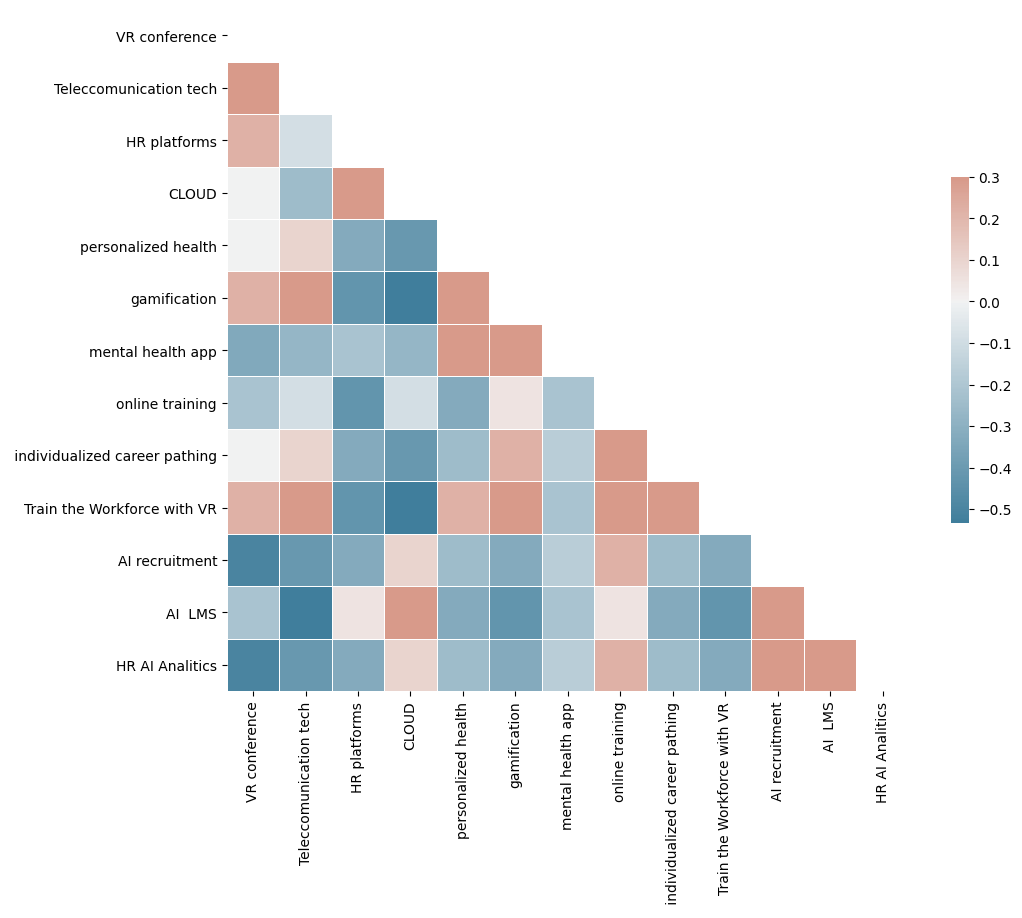

In [0]:
corr = data_to_cluster.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(11, 9))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [0]:
# Кластеризация

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5).fit(corr)
labels = kmeans.labels_
results = pd.DataFrame([corr.index,labels]).T
results

,0,1
0,VR conference,4
1,Teleccomunication tech,4
2,HR platforms,1
3,CLOUD,1
4,personalized health,0
5,gamification,0
6,mental health app,0
7,online training,2
8,individualized career pathing,2
9,Train the Workforce with VR,2


Кластеры соответствуют изначально заложенным.

Теперь попробуем выполнить кластеризацию на первоначальной матрице.

In [0]:
def simple_kmeans(data,n_clusters=5):
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(data)
    labels = kmeans.labels_
    results = pd.DataFrame([data.index,labels]).T
    return results

simple_kmeans(data_to_cluster.T)

,0,1
0,VR conference,0
1,Teleccomunication tech,0
2,HR platforms,4
3,CLOUD,4
4,personalized health,3
5,gamification,3
6,mental health app,3
7,online training,2
8,individualized career pathing,2
9,Train the Workforce with VR,2


Кластеры также совпадают с исходными.
Можно использовать оба способа и сравнить результаты на реальных данных. Также можно использовать Kmeans с Elbow методом для определения оптимального числа кластеров.
Из примера видно, что ключевые фразы нужно отбирать такие, чтобы кол-во статей, где они содержатся было >3,4,5... В зависимости от итогового распределения.

Можно искать метод анализа по запросам (co-word analysis).

## Пример того, как будут выглядеть элементы временного ряда

In [0]:
example = {
    'trend_name': {
        2021: { # Год
            'patents': 18,
            'articles': 30,
            'queries': 34,
            'investments': {
                'numberOfStartups': 13,
                'investmentSize': 10000,
            },
        }
    }
}

### Преобразовываем элементы временного ряда

Для того, чтобы оценить каждый тренд, нам необходимо преобразовать уже нормализованные элементы временного ряда с помощью специальной формулы:

**y = (x1 + x2 + x3 + x5 / x4) / x1**, где **x1** - патенты, **x2** - статьи, **x3** - запросы, **x4** - кол-во стартапов, **x5** - инвестиции в долларах

После получения целевой переменной для каждого года во временном ряде, можно получить график, на котором будет понятно, где тренд зарождается, растет, на пике, угасает или где у него плато.